#Задача: Определить оптимальное число кластеров

Это решение расположено в репозитории https://github.com/crazyelf1971/odb21/

##Описание задачи

https://open-data-battle.geecko.com/issues/paris

Дана выборка недвижимости в Париже в файле ParisHousing.csv

Необходимо определить оптимальное число кластеров для данной выборки при помощи метода **kMeans** с использованием метода “локтя” с шагом 20.

Обратите внимание, что шаг равен 20-ти. Допускаются такие ответы как 60, 120, 140…

##Скачивание данных

Если ссылка на соревнование перестанет быть актуальной, можно будет взять файлы из моего репозитория с решениями https://github.com/crazyelf1971/odb21  
При запуске не из Google Colab можно использовать для скачки библиотеку wget и вызовы os.system, либо просто взять готовый csv файл из репозитория и пропустить этот шаг.

In [2]:
import gdown

file_name = gdown.download('https://open-data-battle.geecko.com/dataset/paris.zip',None, False)
!unzip {file_name}
!ls -la *.csv

Downloading...
From: https://open-data-battle.geecko.com/dataset/paris.zip
To: /content/paris.zip
100%|█████████▉| 323k/324k [00:00<00:00, 2.64MB/s]


Archive:  paris.zip
  inflating: ParisHousing.csv        
-rw-rw-r-- 1 root root 1085813 Aug 18 03:21 ParisHousing.csv


##Загрузка данных

In [9]:
import pandas as pd

df = pd.read_csv('ParisHousing.csv', index_col=0)
df.info(memory_usage='deep')
df.loc[:,df.dtypes=='object'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  object 
 2   floors             10000 non-null  int64  
 3   cityCode           10000 non-null  int64  
 4   cityPartRange      10000 non-null  int64  
 5   numPrevOwners      10000 non-null  int64  
 6   made               10000 non-null  int64  
 7   isNewBuilt         10000 non-null  bool   
 8   hasStormProtector  10000 non-null  bool   
 9   basement           10000 non-null  int64  
 10  attic              10000 non-null  int64  
 11  garage             10000 non-null  int64  
 12  hasStorageRoom     10000 non-null  bool   
 13  hasGuestRoom       10000 non-null  int64  
 14  price              10000 non-null  float64
 15  category           10000 non-null  object 
 16  PoolAndYard        1000

,numberOfRooms,category,PoolAndYard
0,three,Basic,has pool and no yard
1,thirty-nine,Luxury,has pool and has yard
2,fifty-eight,Basic,has pool and no yard
3,forty-seven,Basic,no pool and no yard
4,nineteen,Luxury,has pool and has yard


##Подготовка данных

Видим, что в данных нет пропусков, но есть три признака в виде строк, их нужно преобразовать в числа:
- `numberOfRooms` - числа, написанные словами
- `category` - двоичный признак
- `PoolAndYard` - можно преобразовать в две двоичных колонки (либо одну цифровую)

In [10]:
# преобразование строковых фич в числовые и булевы

def name2number(name):
    d = {
      'twelve': 12,
      'one hundred': 100,
      'six': 6,
      'sixty': 60,
      'sixteen': 16,
      'thirty': 30,
      'ninety': 90,
      'seventeen': 17,
      'two': 2,
      'one': 1,
      'eleven': 11,
      'eight': 8,
      'nine': 9,
      'ten': 10,
      'five': 5,
      'fifty': 50,
      'eighteen': 18,
      'thirteen': 13,
      'four': 4,
      'nineteen': 19,
      'fourteen': 14,
      'seven': 7,
      'seventy': 70,
      'forty': 40,
      'eighty': 80,
      'fifteen': 15,
      'three': 3,
      'twenty': 20
    }
    x = 0
    for k in name.split('-'):
        x += d[k]
    return x

# число комнат
df['numberOfRooms'] = df['numberOfRooms'].apply(name2number)

# бассейн и двор - отдельными OHE признаками
df['hasYard'] = df['PoolAndYard'].str.contains('has yard')
df['hasPool'] = df['PoolAndYard'].str.contains('has pool')
df = df.drop(columns='PoolAndYard')

# категория: простая либо роскошная
df['isLuxury'] = df['category'].str.contains('Luxury')
df = df.drop(columns='category')

##Решение задачи

Используем:
- `MinMaxScaler` - для приведения признаков к одному масштабу
- `KMeans` - для кластеризации
- `silhouette_score` - для определения места перегиба ("локтя") графика сумм расстояний до центров кластеров

Внимание!!!  
Не забываем про шаг `20`, заданный в условии задачи. Без этого ограничения максимальный перегиб согласно `silhouette_score` будет достигнут при `31` кластере.  
Если же забыть про масштабирование, максимум будет уже при `20` кластерах, а если забыть сразу и про масштабирование и про шаг `20`, то максимум будет при количестве кластеров `2`.

Ответ: 40
---------


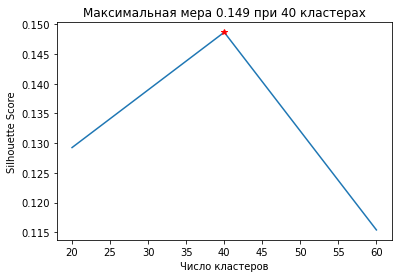

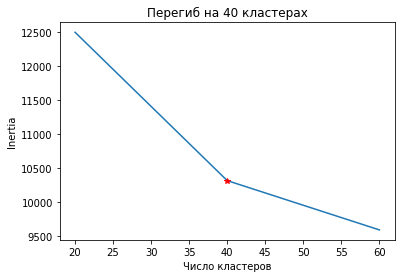

In [21]:
from enum import Enum
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

class Score(Enum):
    inertia = 'inertia'
    silhouette = 'silhouette score'

scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

clusters = []
scores = defaultdict(list)
for k in range(20, 80, 20):
    clusters.append(k)
    kmeans = KMeans(n_clusters=k).fit(data)
    # Inertia: Sum of distances of samples to their closest cluster center
    scores[Score.inertia].append(kmeans.inertia_) 
    preds = kmeans.predict(data)
    scores[Score.silhouette].append(silhouette_score(data, preds))

for score in reversed(Score):
    plt.figure()
    plt.plot(clusters, scores[score])
    plt.xlabel("Число кластеров")
    plt.ylabel(score.value.title());

    if score == Score.silhouette:
        s, k = max(zip(scores[score], clusters))
        plt.title(f'Максимальная мера {s:.3f} при {k} кластерах');
    else:
        s = scores[score][clusters.index(k)]
        plt.title(f'Перегиб на {k} кластерах');

    plt.plot(k, s, 'r*')

print(f'Ответ: {k}\n---------')